# Crunchbase Startup Investments

This code uses data from Crunchbase containing information on investments in various startups up through October 2013.  The data can be obtained through this link: https://github.com/datahoarder/crunchbase-october-2013/blob/master/crunchbase-investments.csv.  The code here seeks to minimize the amount of memory needed to store the data and to help improve the speed of data processing.  As a result, the data is processed in chunks and datatypes are converted into variables that require less storage where possible (e.g. string to categorical, string to int, float to int).  This exercise is able to reduce the memory storage from 45MB to 6MB or a size that is around 7 times smaller than the original file.

In [5]:
#Assume we only have 10MB of available memory for processing
import pandas as pd

temp = pd.read_csv("crunchbase-investments.csv", encoding = "ISO-8859-1", parse_dates=["funded_at"], nrows=20)
print(temp)
print(temp.dtypes)
missing = temp.isnull().sum()
print(missing)
print(temp.memory_usage(deep=True))
print(temp.shape)

missing = temp.isnull().sum()
for key,val in missing.items():
    if missing[key]/len(temp) > 0.25:
        temp = temp.drop(key,1)
print(temp.shape)


          company_permalink       company_name company_category_code  \
0         /company/advercar           AdverCar           advertising   
1       /company/launchgram         LaunchGram                  news   
2             /company/utap               uTaP             messaging   
3         /company/zoopshop           ZoopShop              software   
4         /company/efuneral           eFuneral                   web   
5            /company/tackk              Tackk                   web   
6         /company/acclaimd           Acclaimd             analytics   
7         /company/acclaimd           Acclaimd             analytics   
8         /company/toviefor           ToVieFor             ecommerce   
9         /company/ohk-labs           OHK Labs                sports   
10          /company/lovely             Lovely           real_estate   
11    /company/peertransfer       peerTransfer               finance   
12        /company/spotdock           spotdock                  

In [6]:
import pandas as pd
import numpy as np
import math

#function to check if an item is a percentage
def is_percentage(item):
    if str(item).endswith("%") | str(item).endswith(" MONTHS"):
        try:
            float(item[:-1])
            return True
        except ValueError:
            return False
    else:
        return False

#function to check if an item is a number
def is_number(item):
    try:
        float(item)
        return True
    except ValueError:
        return False

#Function to automate the data compression tasks
def compress_chunk(chunk, has_id):
    #check to make sure that id is valid otherwise exceptions are thrown in the data and storage is not efficient (occurs at tail of data)
    if has_id == 1:
        id_is_valid = chunk.apply(lambda item: is_number(item[0]), axis=1)
        chunk = chunk.loc[id_is_valid == True]
        #print("Problem w/selection")

    #select string types
    string_cols = chunk.select_dtypes(include=["object"])
    for s in string_cols.columns:
        chunk[s]= chunk[s].fillna("")
        chunk[s] = chunk[s].str.rstrip()
        #check if the column can be mostly considered a percentage or number (threshold 0.95)
        col_is_percentage = chunk.apply(lambda item: is_percentage(item[s]), axis=1)
        col_is_number = chunk.apply(lambda item: is_number(item[s]), axis=1)
        #print("Column is number:", col_is_number.sum())
        #print(len(col_is_number))
        #print(col_is_percentage.sum())
        #print(len(col_is_percentage))
        if col_is_percentage.sum()/len(col_is_percentage) > 0.95:
            #print("Change to float: ", s)
            chunk[s] = chunk[s].str.rstrip("%")
            chunk[s] = chunk[s].str.rstrip(" MONTHS")
            chunk[s] = chunk[s].astype(float)
        elif col_is_number.sum()/len(col_is_number) > 0.95:
            print(s)
            #drop rows that do not conform to the number requirements so errors are not thrown
            chunk = chunk[col_is_number==True]
            chunk[s] = chunk[s].astype(float,errors="ignore")
        else:
            share_unique = len(string_cols[s].unique())/len(string_cols[s])
            #Make sure that these columns are not subject issues due to case values (put everything into upper case)
            chunk[s] = [st.upper() if st is not None else "" for st in chunk[s].astype(str)]
            if share_unique < 0.50:
                #if a small share is unique and the largest value count is the majority then drop this column from data
                cnt_large_value = chunk[s].value_counts()[0]
                if cnt_large_value/len(chunk[s]) >= 0.99:
                    chunk = chunk.drop(s, 1)
                else:
                    #just change to a category column otherwise
                    #print("Change to category: ", s)
                    chunk[s] = chunk[s].astype("category")
                    #print("error here")
    #want to check for float cols that are really integers
    #that is floor(col) = round(col)
    #dataset['deff'] = np.where(dataset['2016-11'] >= dataset['2016-12'], 0,1)
    float_cols = chunk.select_dtypes(include=["float"])
    float_int_cols = []
    for f in float_cols.columns:
        #Also check if there is little variation in the float columns and drop these columns
        if float_cols[f].std() < 0.0001:
            #print("Dropping", f)
            chunk = chunk.drop(f, 1)
        else:
            temp_floor = np.floor(chunk[f]*10)
            temp_round = np.round(chunk[f]*10,0)
            cnt_diff = np.where(temp_floor==temp_round,0,1).sum()
            #if seems like everything is an integer
            if cnt_diff == 0:
                #print("Downcasting", f)
                float_int_cols.append(f)
    for f in float_int_cols:
        chunk[f]=pd.to_numeric(chunk[f],downcast="integer")
    #Drop columns that have too many missing values (greater than 50%)
    missing = chunk.isnull().sum()
    for key,val in missing.items():
        if missing[key]/len(chunk) > 0.50:
            chunk = chunk.drop(key, 1)
    return chunk

# Function to determine optimal chunk size based on memory constraint
def optimal_chunk(file, maxmb, encodeval):
    mem = 0
    numrows = 0
    while mem < maxmb:
        numrows += 500
        temp = pd.read_csv(file, nrows=numrows, encoding=encodeval)
        mem = temp.memory_usage(deep=True).sum()/1048576
    return numrows-500

def compress_data(file,maxmb,dropcols,encodeval,parsedatecols,has_id=0):
    memory_footprints_full = []
    memory_footprints = []
    
    #obtain optimal chunk size
    opt_chunk = optimal_chunk(file, maxmb, encodeval)
    print("Optimal chunk for {}MB: {}".format(maxmb, opt_chunk))
    
    # Get the memory usage needed prior to compression
    chunk_iter = pd.read_csv(file, chunksize=opt_chunk, encoding=encodeval, parse_dates=parsedatecols)
    for chunk in chunk_iter:
        memory_footprints_full.append(chunk.memory_usage(deep=True).sum()/1048576)
    total_memory_usage = sum(memory_footprints_full)
    print("Memory usage (prior to compression): {}".format(round(total_memory_usage,2)))
    
    keep_cols = []
    temp = pd.read_csv(file, nrows=2, parse_dates=parsedatecols)
    print("Number of columns in original file: {}".format(len(temp.columns)))
    for c in temp.columns:
        if c not in dropcols:
            keep_cols.append(c)
    print("Keep columns: ", keep_cols)

    # Create synthetic data that will help us identify crucial columns to keep so we do not have to read into data frame
    temp = pd.read_csv(file, nrows=opt_chunk, usecols=keep_cols, encoding=encodeval, parse_dates=parsedatecols)
    temp = compress_chunk(temp,has_id)
    print("Number of columns to keep: {}".format(len(temp.columns)))
    print(temp.columns)
    newdata = []
    # use the optimal chunk size and columns to keep to read in the chunks
    chunk_iter = pd.read_csv(file, usecols=temp.columns, encoding=encodeval, chunksize=opt_chunk, parse_dates=parsedatecols)
    for chunk in chunk_iter:
        chunk = compress_chunk(chunk,has_id)       
        memory_footprints.append(chunk.memory_usage(deep=True).sum()/1048576)
        #merge data into new set
        newdata.append(chunk)
        #try:
        #    newdata=pd.concat([newdata, chunk], axis=0)
        #except NameError:
        #    newdata=chunk
    total_memory_usage = sum(memory_footprints)
    print("Memory usage (after compression): {}".format(round(total_memory_usage,2)))
    #print("Memory usage (newdata): {}".format(round(newdata.memory_usage(deep=True).sum()/1048576,2)))
    return newdata

In [7]:
from datetime import datetime

#columns that are a repeat of earlier columns
drop_cols = ["company_permalink","investor_permalink","investor_region","funded_quarter","funded_month","funded_year"]
compressed_data = compress_data("crunchbase-investments.csv", 5, dropcols = drop_cols, encodeval="ISO-8859-1", parsedatecols=["funded_at"], has_id=0)

Optimal chunk for 5MB: 4000
Memory usage (prior to compression): 53.92
Number of columns in original file: 20
Keep columns:  ['company_name', 'company_category_code', 'company_country_code', 'company_state_code', 'company_region', 'company_city', 'investor_name', 'investor_category_code', 'investor_country_code', 'investor_state_code', 'investor_city', 'funding_round_type', 'funded_at', 'raised_amount_usd']
Number of columns to keep: 13
Index(['company_name', 'company_category_code', 'company_state_code',
       'company_region', 'company_city', 'investor_name',
       'investor_category_code', 'investor_country_code',
       'investor_state_code', 'investor_city', 'funding_round_type',
       'funded_at', 'raised_amount_usd'],
      dtype='object')
Memory usage (after compression): 6.11


In [8]:
print(compressed_data[0].dtypes)
print(compressed_data[0].head(5))

company_name                      object
company_category_code           category
company_state_code              category
company_region                  category
company_city                    category
investor_name                   category
investor_category_code          category
investor_country_code           category
investor_state_code             category
investor_city                   category
funding_round_type              category
funded_at                 datetime64[ns]
raised_amount_usd                float64
dtype: object
  company_name company_category_code company_state_code  \
0     ADVERCAR           ADVERTISING                 CA   
1   LAUNCHGRAM                  NEWS                 CA   
2         UTAP             MESSAGING                      
3     ZOOPSHOP              SOFTWARE                 OH   
4     EFUNERAL                   WEB                 OH   

          company_region   company_city      investor_name  \
0                 SF BAY  SAN FRANCI

In [10]:
#loading chunks into sqlite
import sqlite3
conn = sqlite3.connect('crunchbase.db')

cur = conn.cursor()

#Make sure we start with a new table so we don't just keep appending and it grows bigger in size
query = "DROP TABLE investments;"
cur.execute(query)

#takes the data from the compressed data file:
for data in compressed_data:
    data.to_sql("investments",conn, if_exists='append', index=False)
    
query = "PRAGMA table_info(investments);"
results = pd.read_sql(query,conn)
print(results)



    cid                    name       type  notnull dflt_value  pk
0     0            company_name       TEXT        0       None   0
1     1   company_category_code       TEXT        0       None   0
2     2      company_state_code       TEXT        0       None   0
3     3          company_region       TEXT        0       None   0
4     4            company_city       TEXT        0       None   0
5     5           investor_name       TEXT        0       None   0
6     6  investor_category_code       TEXT        0       None   0
7     7   investor_country_code       TEXT        0       None   0
8     8     investor_state_code       TEXT        0       None   0
9     9           investor_city       TEXT        0       None   0
10   10      funding_round_type       TEXT        0       None   0
11   11               funded_at  TIMESTAMP        0       None   0
12   12       raised_amount_usd       REAL        0       None   0


In [11]:
import os
#!wc

In [12]:
#Use the panas SQLite workflow to answer following questions
cur = conn.cursor()

#1. Proportion of total amount of funds the top 10% raised? Top 1%?
#compare to proportions of bottom 10% and bottom 1%

query0 = "CREATE TABLE new_table AS SELECT company_name, ROUND(SUM(raised_amount_usd)/1000000,1) AS total_amount FROM investments GROUP BY company_name ORDER BY total_amount DESC;"
cur.execute(query0)
query0a = "SELECT * FROM new_table LIMIT 10;"
print(pd.read_sql(query0a,conn))

query1 = "CREATE TABLE temp_computations AS SELECT company_name, total_amount, ROWID, (SELECT MAX(ROWID) FROM new_table) AS num_rows, ROWID*1.0/(SELECT MAX(ROWID) FROM new_table) AS percent, CASE WHEN ROWID*1.0/(SELECT MAX(ROWID) FROM new_table) < 0.1 THEN total_amount ELSE 0 END top10, CASE WHEN ROWID*1.0/(SELECT MAX(ROWID) FROM new_table) < 0.01 THEN total_amount ELSE 0 END top1, CASE WHEN ROWID*1.0/(SELECT MAX(ROWID) FROM new_table) > 0.99 THEN total_amount ELSE 0 END bottom1, CASE WHEN ROWID*1.0/(SELECT MAX(ROWID) FROM new_table) > 0.90 THEN total_amount ELSE 0 END bottom10 FROM new_table;"
cur.execute(query1)

#Now query from the temp_computations table to compute proportion of funds
query2 = "SELECT DISTINCT SUM(top1)/SUM(total_amount) AS top1share, SUM(top10)/SUM(total_amount) AS top10share, SUM(bottom10)/SUM(total_amount) AS bottom10share, SUM(bottom10)/SUM(total_amount) AS bottom1share FROM temp_computations;"
results = pd.read_sql(query2,conn)
print(results)

query3 = "DROP TABLE temp_computations;"
cur.execute(query3)

query4 = "DROP TABLE new_table;"
cur.execute(query4)

        company_name  total_amount
0          CLEARWIRE       29680.0
1            GROUPON       10185.4
2          NANOSOLAR        4505.0
3           FACEBOOK        4154.1
4       SURVEYMONKEY        3250.0
5              ZYNGA        2886.0
6  FISKER AUTOMOTIVE        2788.0
7            DROPBOX        2764.4
8       LIVINGSOCIAL        2685.0
9          SIGMACARE        2600.0
   top1share  top10share  bottom10share  bottom1share
0   0.262175    0.671272            0.0           0.0


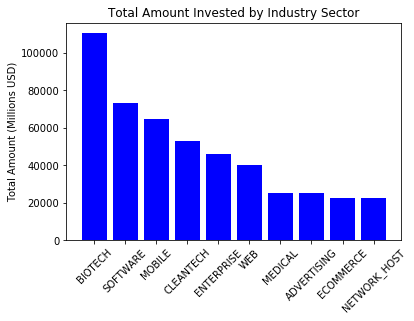

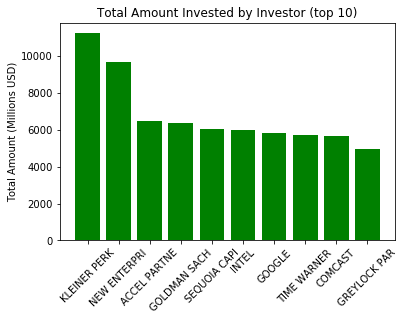

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

#A lot of column names are too long let's truncate it for ease of usage
#df = df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'})

def format_bargraphs(barnames,yval,colorname):
    # have maximum length of 10 for the character names
    #print(results)
    new_bar_values = []
    for string in barnames:
        if len(string) > 12:
            new_bar_values.append(string[:12])
        else:
            new_bar_values.append(string)
    y_pos = np.arange(len(yval))
    plt.bar(y_pos, yval, color=colorname)
    plt.xticks(y_pos, new_bar_values, rotation=45)


#2. Which category of companies attracted the most investments
query = "SELECT company_category_code, ROUND(sum(raised_amount_usd)/1000000,1) as total_category FROM investments GROUP BY company_category_code ORDER BY total_category DESC LIMIT 10;"
results = pd.read_sql(query,conn)
format_bargraphs(results["company_category_code"],results["total_category"],"blue")
plt.ylabel("Total Amount (Millions USD)")
plt.title("Total Amount Invested by Industry Sector")
plt.show()

#3. Which investor contributed the most money across all startups?
query = "SELECT DISTINCT investor_name, ROUND(sum(raised_amount_usd)/1000000,1) as total_investor FROM investments GROUP BY investor_name ORDER BY total_investor DESC LIMIT 10;"
results = pd.read_sql(query,conn)
format_bargraphs(results["investor_name"],results["total_investor"],"green")
plt.ylabel("Total Amount (Millions USD)")
plt.title("Total Amount Invested by Investor (top 10)")
plt.show()


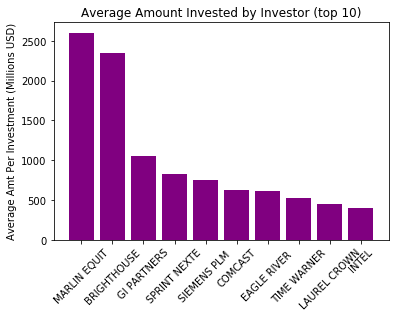

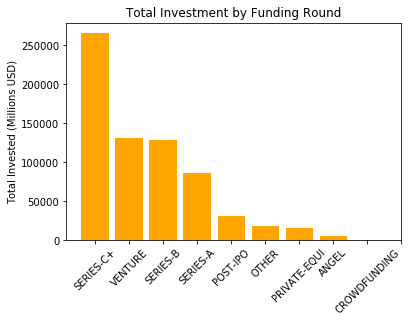

In [14]:
#4. Which investor contributed the most money per startup
query = "SELECT DISTINCT investor_name, ROUND(AVG(raised_amount_usd)/1000000,1) as mean_investment FROM investments GROUP BY investor_name ORDER BY mean_investment DESC LIMIT 10;"
results = pd.read_sql(query,conn)
format_bargraphs(results["investor_name"],results["mean_investment"],"purple")
plt.ylabel("Average Amt Per Investment (Millions USD)")
plt.title("Average Amount Invested by Investor (top 10)")
plt.show()


#5. Which funding round was the most popular, which funding round the least popular
query = "SELECT funding_round_type, ROUND(SUM(raised_amount_usd)/1000000,1) as total_investment FROM investments GROUP BY funding_round_type ORDER BY total_investment DESC LIMIT 10;"
results = pd.read_sql(query,conn)
format_bargraphs(results["funding_round_type"],results["total_investment"],"orange")
plt.ylabel("Total Invested (Millions USD)")
plt.title("Total Investment by Funding Round")
plt.show()

## Conclusions

The analysis shows that biotech companies have received the most startup funding over time (500 trillion) with software companies coming in second at 350 trillion.  It is also observed that there are some large players in the startup market that account for a large portion of investments.  In particular, Kleiners, Perkins and Caufield has accounted for close to 60 trillion in investments.  Nevertheless the big players appear to diversify their investments over more companies and most do not show up on the top 10 list of firms that are in the top 10 per amount invested.  The exception here is TimeWarner.  Not surprisingly most investment comes in the late stage of development (meaning series C investments) when there is greater assurance of success.

### Future data work

Reduce memory constraints further by converting float values into float and integer values requiring smaller storage space, deleting rows that have key missing variables.  The data could also be linked to the other data in the repository and a relational database designed to link the datasets together and reduce overall disk space.